### LITTLE EYES V5
#### Meu Quinto Modelo de Visão Computacional

Validação cruzada / controle de parada para selecionar o modelo mais genérico

In [1]:
# NETWORK
the_seed = 32
digit_size = (28, 28, 1)
convnn_activation = 'relu'
fully_connected_activation = 'tanh'
hyperparameter_max = 3
phi_step, max_phi = 5, 15
learning_rate = 0.01
patience = 5
max_epochs = 5*patience
score_metric = 'accuracy'
verbose = 0
batch_size = None

# VALIDATION
n_folds = 3

In [2]:
import tensorflow
from tensorflow.keras import datasets, models, layers, optimizers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
import numpy
import pandas
import random
from sklearn.model_selection import StratifiedKFold
from seaborn import boxplot
from sklearn.metrics import accuracy_score

In [3]:
random.seed(the_seed)
numpy.random.seed(the_seed)
tensorflow.random.set_seed(the_seed)

In [4]:
def create_little_eyes(digit_size : tuple[int, int, int] = (28, 28, 1),
                       convnn_activation : str = 'relu',
                       fully_connected_activation : str = 'tanh',
                       net_name : str = 'LittleEyes',
                       hyperparameter : int = 1,
                       phi : float = 0.0):
    # CAMADA DE ENTRADA
    inputs = Input(shape=digit_size)

    # CAMADA DE AUMENTO DE DADOS
    rotator = layers.RandomRotation(phi)
    x = rotator(inputs)

    # PRIMEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_1 = layers.Conv2D(2*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_1(x)

    # PRIMEIRA CAMADA MAX POOLING
    maxpool_1 = layers.MaxPooling2D((2, 2))
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL
    conv_2d_layer_2 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_2(x)

    # SEGUNDA CAMADA MAX POOLING
    maxpool_2 = layers.MaxPooling2D((2, 2))
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL
    conv_2d_layer_3 = layers.Conv2D(4*hyperparameter, (3, 3), activation=convnn_activation)
    x = conv_2d_layer_3(x)

    # TERCEIRA CAMADA MAX POOLING
    maxpool_3 = layers.MaxPooling2D((2, 2))
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = layers.Dense(hyperparameter + 1, activation=fully_connected_activation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = layers.Dense(10)
    outputs = output_layer(x)

    return Model(inputs=inputs, outputs=outputs, name=net_name)

In [5]:
(train_images, train_labels), (validation_images, validation_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0

In [6]:
train_images.shape, validation_images.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
numpy.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [8]:
result_list = []
kfolder = StratifiedKFold(n_splits=n_folds, random_state=the_seed, shuffle=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, verbose=verbose)
for hyperparameter in numpy.arange(1, hyperparameter_max+1):
    for phi in numpy.arange(0, max_phi+phi_step, phi_step):
        for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
            X_train, Y_train = train_images[train_index], train_labels[train_index]
            X_val, Y_val = train_images[validation_index], train_labels[validation_index]

            # NET NAME > Hyperparameter + Fold Number
            net_name = f"0_0_{hyperparameter}-{phi}_{i}"
            print(f"{net_name} training started...")
            little_eyes = create_little_eyes(net_name = net_name,
                                             hyperparameter=hyperparameter,
                                             phi=phi)
            opt = optimizers.Adam(learning_rate=learning_rate)
            little_eyes.compile(optimizer=opt,
                        loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[score_metric])

            history = little_eyes.fit(X_train, Y_train, epochs=max_epochs, 
                                    validation_data=(X_val, Y_val),
                                    verbose=verbose,
                                    batch_size=batch_size,
                                    callbacks=[early_stopping])

            training_score = history.history[score_metric][-1]
            validation_score = history.history[f"val_{score_metric}"][-1]
            result_list.append((net_name, hyperparameter, phi, i, training_score, validation_score, little_eyes, history))
            print(f"{net_name.upper()}: {100*training_score:.0f}% TRAINING {score_metric.upper()} / {100*validation_score:.0f}% VALIDATION {score_metric.upper()}")
        

Olhinho_1-0_0 training started...
OLHINHO_1-0_0: 74% TRAINING ACCURACY / 70% VALIDATION ACCURACY
Olhinho_1-0_1 training started...
OLHINHO_1-0_1: 74% TRAINING ACCURACY / 75% VALIDATION ACCURACY
Olhinho_1-0_2 training started...
OLHINHO_1-0_2: 76% TRAINING ACCURACY / 74% VALIDATION ACCURACY
Olhinho_1-5_0 training started...
OLHINHO_1-5_0: 42% TRAINING ACCURACY / 37% VALIDATION ACCURACY
Olhinho_1-5_1 training started...
OLHINHO_1-5_1: 44% TRAINING ACCURACY / 41% VALIDATION ACCURACY
Olhinho_1-5_2 training started...
OLHINHO_1-5_2: 44% TRAINING ACCURACY / 42% VALIDATION ACCURACY
Olhinho_1-10_0 training started...
OLHINHO_1-10_0: 11% TRAINING ACCURACY / 10% VALIDATION ACCURACY
Olhinho_1-10_1 training started...
OLHINHO_1-10_1: 45% TRAINING ACCURACY / 44% VALIDATION ACCURACY
Olhinho_1-10_2 training started...
OLHINHO_1-10_2: 33% TRAINING ACCURACY / 32% VALIDATION ACCURACY
Olhinho_1-15_0 training started...
OLHINHO_1-15_0: 45% TRAINING ACCURACY / 41% VALIDATION ACCURACY
Olhinho_1-15_1 trainin

In [ ]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", "hyperparameter", "phi", "kfold", score_metric, f"val_{score_metric}", "little_eyes", 'history']
results.sort_values("val_accuracy", ascending=False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,little_eyes,history
16,LittleEyes_4_1,4,1,0.951958,0.954083,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
12,LittleEyes_3_2,3,2,0.949146,0.953833,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
14,LittleEyes_3_4,3,4,0.953167,0.953250,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
24,LittleEyes_5_4,5,4,0.948292,0.951250,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001568...
15,LittleEyes_4_0,4,0,0.940938,0.941167,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
17,LittleEyes_4_2,4,2,0.946229,0.941083,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
21,LittleEyes_5_1,5,1,0.943083,0.935500,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001568...
20,LittleEyes_5_0,5,0,0.928937,0.934917,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001568...
13,LittleEyes_3_3,3,3,0.939896,0.934667,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...
11,LittleEyes_3_1,3,1,0.937792,0.933583,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x00000156A...


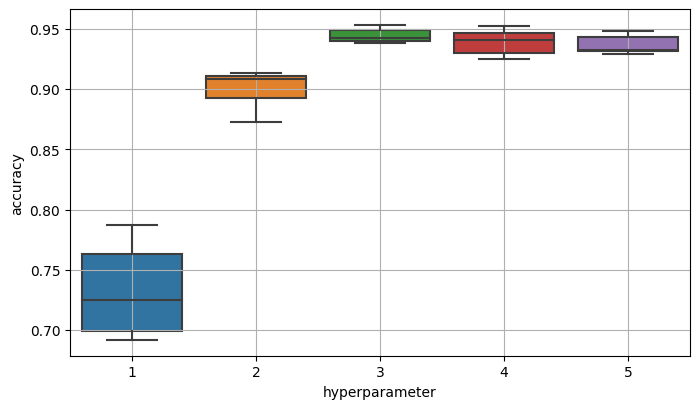

In [ ]:
fig = pyplot.figure(figsize=(8, 4.5))
ax = fig.add_subplot(111)
boxplot(results, x="hyperparameter", y="accuracy", ax=ax)
ax.grid()

In [ ]:
little_eyes = results.sort_values('val_accuracy', ascending=False).head(1)['little_eyes'].values[0]
little_eyes_history = results.sort_values('val_accuracy', ascending=False).head(1)['history'].values[0]
little_eyes

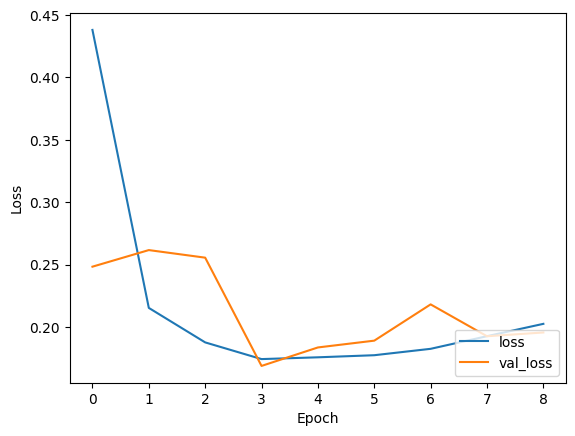

In [ ]:
pyplot.plot(little_eyes_history.history['loss'], label='loss')
pyplot.plot(little_eyes_history.history['val_loss'], label = 'val_loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
# pyplot.ylim([0.5, 1])
pyplot.legend(loc='lower right')

In [ ]:
Y_test = little_eyes.predict(validation_images)

313/313 [==============================] - 2s 4ms/step


In [ ]:
Y_predicted = numpy.argmax(Y_test, axis=1)
Y_predicted

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

TRUE NUMBER 1 >> PREDICTED NUMBER 1


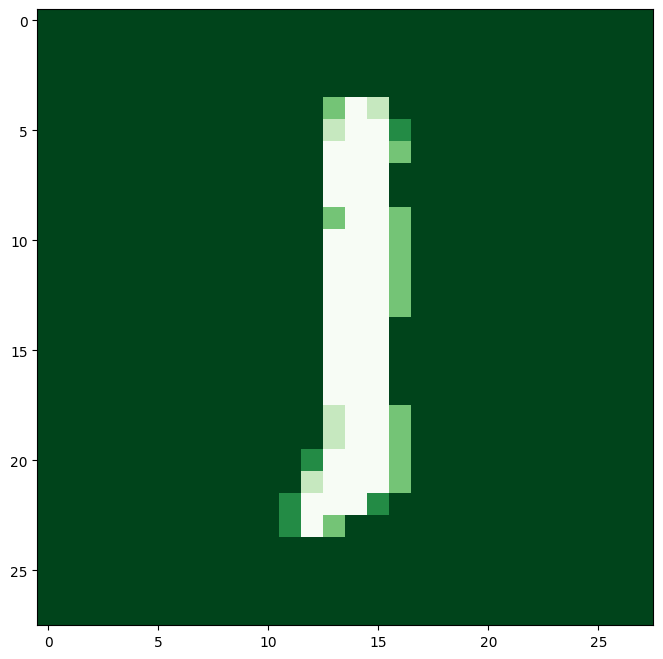

In [ ]:
# TABAJARA VALIDATOR
image_id = 14
print(f"TRUE NUMBER {validation_labels[image_id]} >> PREDICTED NUMBER {Y_predicted[image_id]}")
# Y_test[image_id, :]
fig = pyplot.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
_ = pyplot.imshow(validation_images[image_id], cmap="Greens_r")

In [ ]:
accuracy_score(validation_labels, Y_predicted)

0.9583

0.9583